In [1]:
import pathconfig
import matplotlib.pyplot as plt
import dbtools as dbt
import datetime
import seaborn as sns

sns.set()
%matplotlib inline


today = datetime.date.today()

In [2]:
rdt_q  = """
SELECT * FROM tweetcounts
WHERE "user" = 'realDonaldTrump'
"""

tweets = dbt.select(rdt_q, con=dbt.PI_PROD)
tweets['prevt'] = tweets['tweets'].shift(1)
tweets = tweets[tweets['tweets']!=tweets['prevt']]
tweets['tweets'] -= tweets['tweets'].min()
tweets['tweets'] += 1
tweets = tweets.reset_index(drop=True)
tweets['date'] = tweets['update_ts'].map(
    lambda x: x.to_pydatetime().date())
tweets['wd'] = tweets['date'].map(lambda x: '{:%a}'.format(x))
tweets = tweets[tweets['date']!=today]
tweets.tail()

,update_ts,user,tweets,prevt,date,wd
950,2020-02-16 19:46:09.923552,realDonaldTrump,682,49057.0,2020-02-16,Sun
951,2020-02-16 20:57:27.355706,realDonaldTrump,683,49056.0,2020-02-16,Sun
952,2020-02-16 20:58:27.647764,realDonaldTrump,682,49057.0,2020-02-16,Sun
953,2020-02-16 21:46:53.577608,realDonaldTrump,683,49056.0,2020-02-16,Sun
954,2020-02-16 21:47:55.773790,realDonaldTrump,682,49057.0,2020-02-16,Sun


In [3]:
tweet_count = tweets['tweets'].max() - tweets['tweets'].min()
day_count = (tweets['date'].max() - tweets['date'].min()).days
tpd = tweet_count / day_count
print(f'Tweets: {tweet_count}')
print(f'Days: {day_count}')
print(f'Tweet Rate: {tpd:.1f}')

Tweets: 682
Days: 20
Tweet Rate: 34.1


C:\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(array([737453., 737456., 737460., 737464., 737468., 737472.]),
 <a list of 6 Text xticklabel objects>)

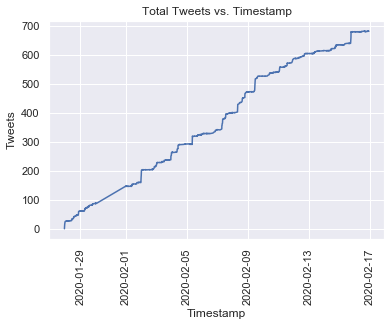

In [4]:
plt.figure()
plt.plot(tweets['update_ts'], tweets['tweets'])
plt.title('Total Tweets vs. Timestamp')
plt.xlabel('Timestamp')
plt.ylabel('Tweets')
plt.xticks(rotation=90)

In [5]:
date_group = tweets.groupby('date')
date_stats = date_group[['tweets', 'wd']].nth(-1)
date_stats = date_stats.reset_index()
date_stats['chg'] = date_stats['tweets'] - date_stats['tweets'].shift(1)
date_stats.tail()

,date,tweets,wd,chg
16,2020-02-12,605,Wed,17.0
17,2020-02-13,616,Thu,11.0
18,2020-02-14,635,Fri,19.0
19,2020-02-15,680,Sat,45.0
20,2020-02-16,682,Sun,2.0


(array([737453., 737456., 737460., 737464., 737468., 737472.]),
 <a list of 6 Text xticklabel objects>)

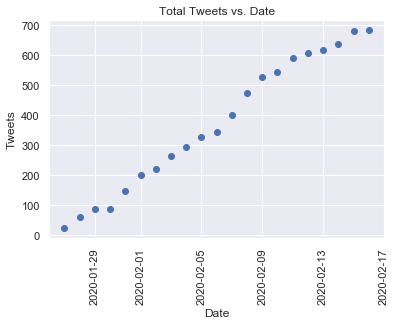

In [6]:
plt.figure()
plt.plot(date_stats['date'], date_stats['tweets'], 'o')
plt.title('Total Tweets vs. Date')
plt.xlabel('Date')
plt.ylabel('Tweets')
plt.xticks(rotation=90)

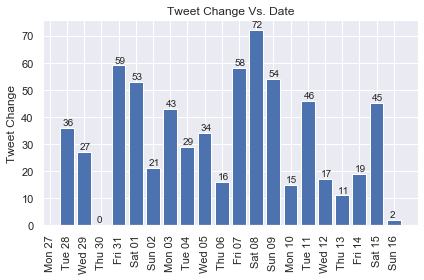

In [7]:
plt.figure()
tick_labels = ['{:%a %d}'.format(x)
               for x in date_stats['date'].tolist()]
plt.bar(date_stats['date'].index,
        date_stats['chg'],
        tick_label=tick_labels)
plt.xticks(rotation=90)
for i,r in date_stats.iterrows():
    plt.annotate('{:,.0f}'.format(r['chg']),
                 (i - 0.25, r['chg'] + 1))
plt.title('Tweet Change Vs. Date')
plt.ylabel('Tweet Change')
plt.tight_layout()

In [8]:
wd_temp = date_stats.copy()
wd_temp['i'] = wd_temp['date'].map(lambda x: '{:%w}'.format(x))
wd_group = wd_temp.groupby('wd')
wd_stats = wd_group.agg({'chg': ['mean', 'std', 'count'],
                         'i': ['max']})
wd_stats.columns = [x[0] + x[1].title()
                    for x in wd_stats.columns]
wd_stats = wd_stats.rename(columns={'iMax': 'dayIdx'})
wd_stats = wd_stats.sort_values('dayIdx')
wd_stats = wd_stats.drop('dayIdx', axis=1)
wd_stats

,chgMean,chgStd,chgCount
wd,,,
Sun,25.666667,26.312228,3
Mon,29.000000,19.798990,2
Tue,37.000000,8.544004,3
Wed,26.000000,8.544004,3
Thu,9.000000,8.185353,3
Fri,45.333333,22.810816,3
Sat,56.666667,13.868429,3


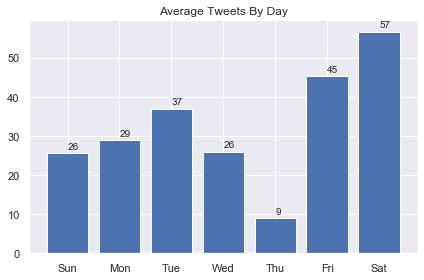

In [14]:
plt.bar(wd_stats.index,
        wd_stats['chgMean'])
plt.title('Average Tweets By Day')
for i,r in wd_stats.iterrows():
    plt.annotate('{:,.0f}'.format(r['chgMean']),
                 (i, r['chgMean'] + 1))
plt.tight_layout()